## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalConstants,
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
# from learning import ModelTrainer, ModelTester, LearningParams
from learning import LearningParams
from learning.cost import CostModelTrainer, DualModelTester

Declare reward function used in training

In [5]:
# allAgents = ModelTrainer.trainAgents()
import math
def rewardFnCost(totalOutputTarget, totalOutputDestination, totalCost):
    totalCost = totalCost/(10000*100.0)
    outputDifferential = (totalOutputDestination - totalOutputTarget)/totalOutputTarget
    costComponent = 2**(-(totalCost**2)*200)
    outputComponent = 2**(-(outputDifferential**2)*500)
    earnedReward = costComponent*outputComponent

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total': earnedReward}

# allAgents = CostModelTrainer.trainAgents(rewardFn)

In [6]:
LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=15000, # Number of learning episodes to run
    maxSteps=200,   # Number of steps per learning episode
    traceLength=8,     # Number of steps each sampled episode should contain
    batchSize=4,     # Number of episodes sampled from experience buffer
    electricalSystemSpecs = None,
#     modelName='Test-Cost_Learning-No_Droop-65'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=None, gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=15000, maxSteps=200, traceLength=8, batchSize=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='DefaultModel')

In [8]:
STEPS_TO_TEST = 300

testSpecs = ElectricalSystemSpecs(
    loads=[LoadSpecs(id_="L1", basePower=3.15, noiseLevel=0.1)],
    generators=[
        GeneratorSpecs(id_="G1", basePower=2, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.1),
        GeneratorSpecs(id_="G2", basePower=2, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.1),
    ],
    shouldTrackOptimalCost=True,
    )

# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


# electricalSystem, rewards = ModelTester.testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)
electricalSystem, allRewards = DualModelTester().testAgents(
    electricalSystemSpecs=testSpecs, 
    modelNameFreq='Test-Frequency_Learning-15k', 
    modelNameCost='Test-Cost_Learning-No_Droop-65', 
    rewardFnCost=rewardFnCost, 
    stepsToTest=STEPS_TO_TEST,
    frequencyWeight=0.7,
)

Alternatively, one can plot the data to better inspect the progression

In [9]:
import matplotlib.pyplot as plt
from plots import plotAll

Plot the reward progression of the model testing

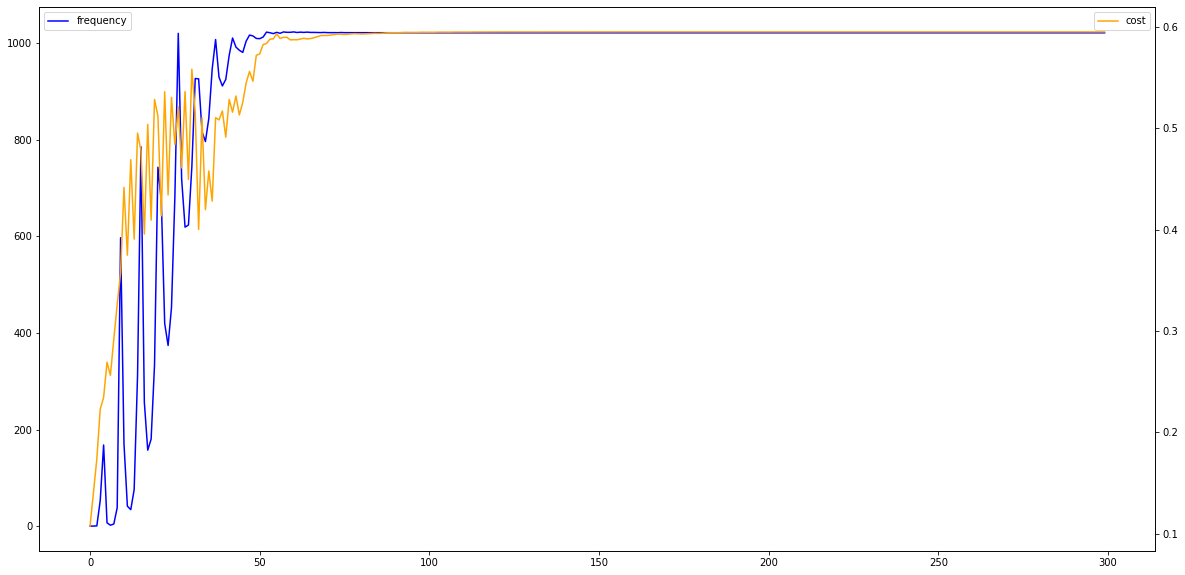

In [10]:
steps = range(STEPS_TO_TEST)
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax1.plot(steps, allRewards['frequency'], color='blue', label='frequency')
ax1.legend(loc='upper left')
ax2.plot(steps, allRewards['cost'], color='orange', label='cost')
ax2.legend(loc='upper right')


# plotExperimentRewardProgression

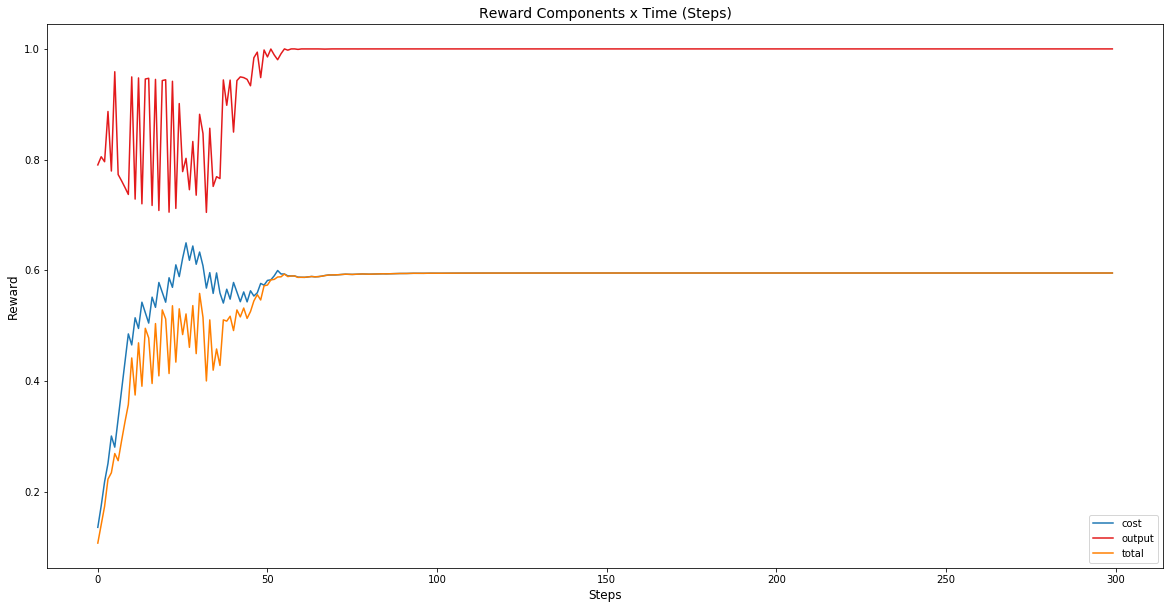

In [11]:
from plots import plotRewardComponents
plotRewardComponents(allRewards['cost_components'])

Plot all graphs related to the electrical system state during the model testing

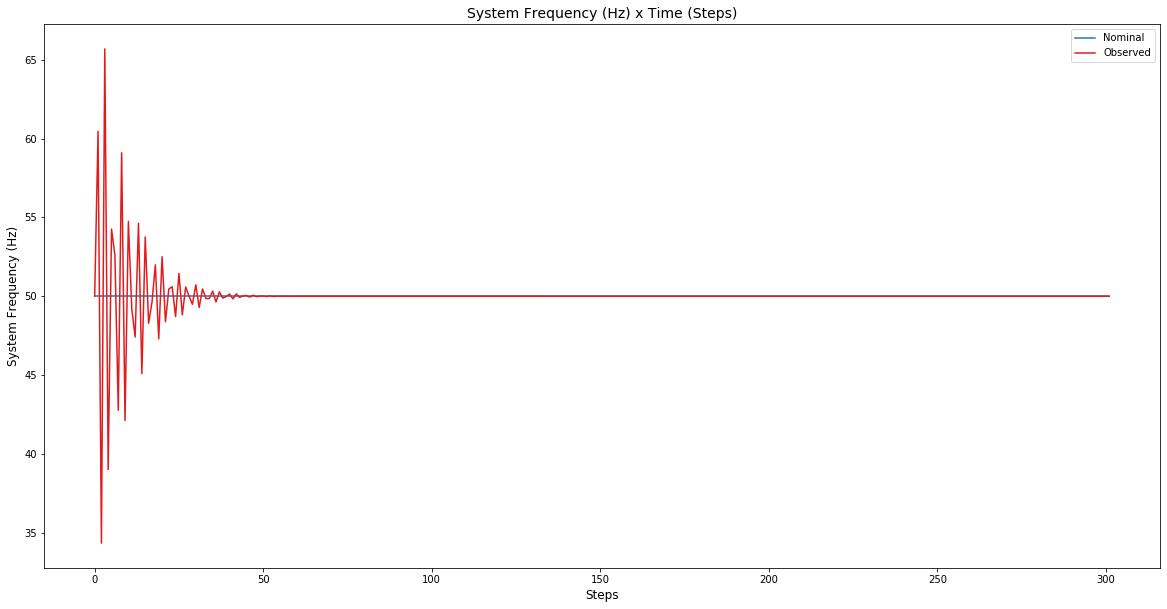

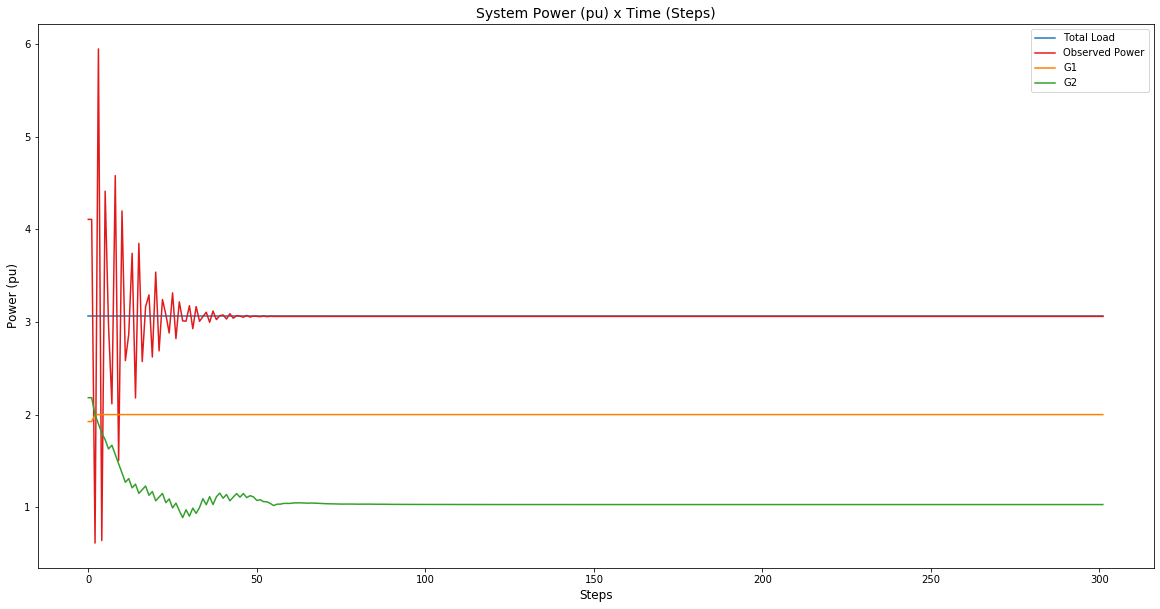

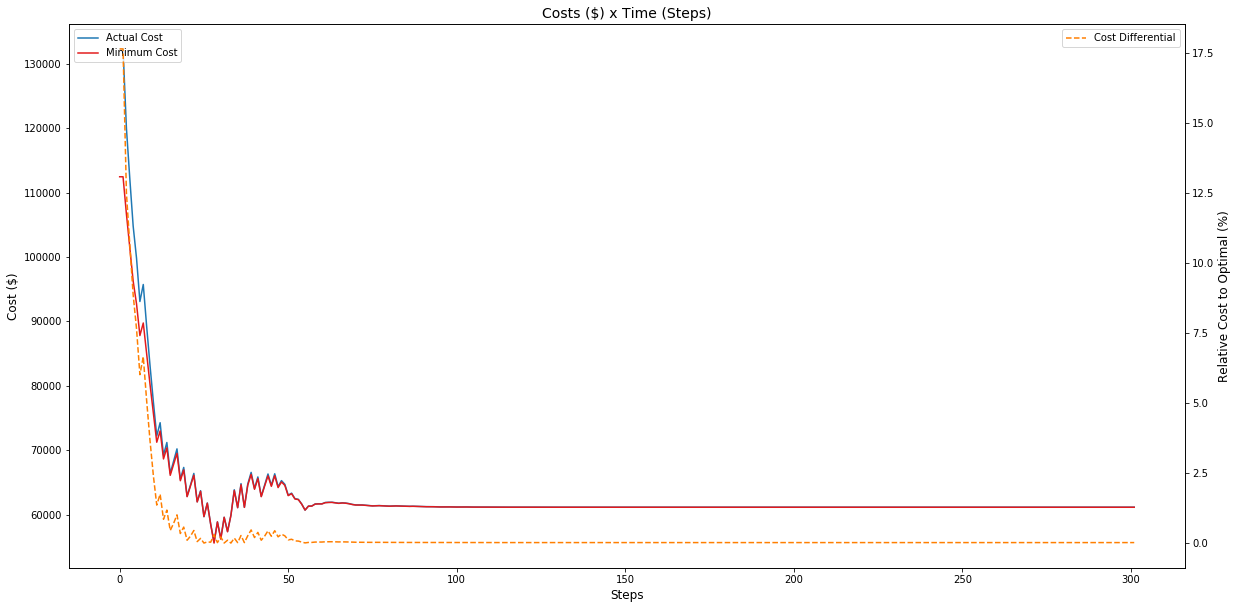

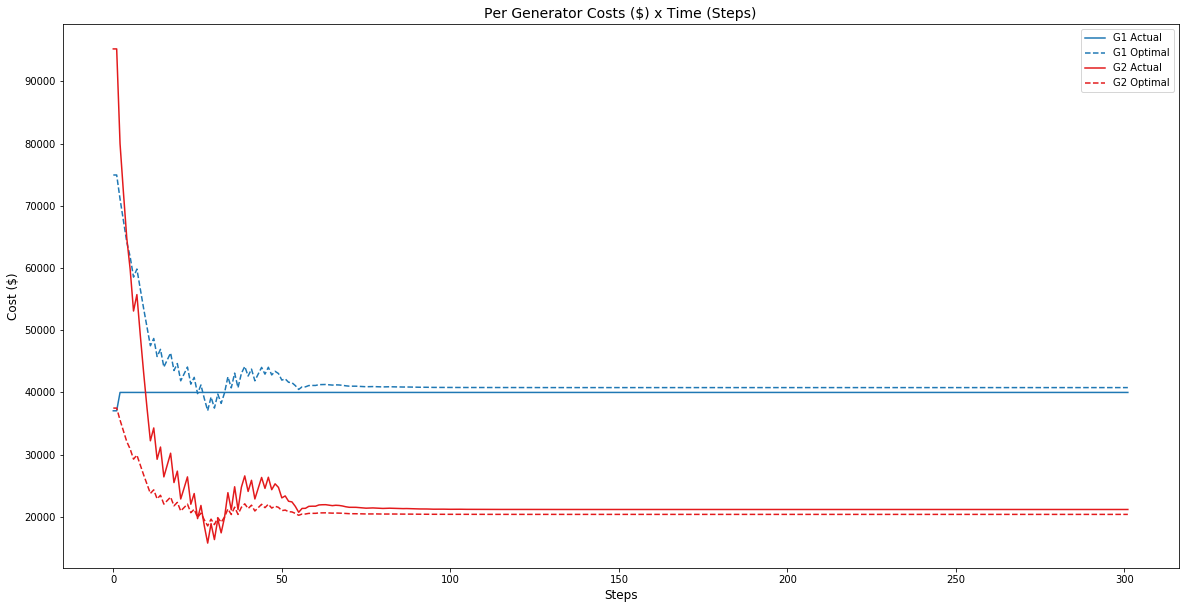

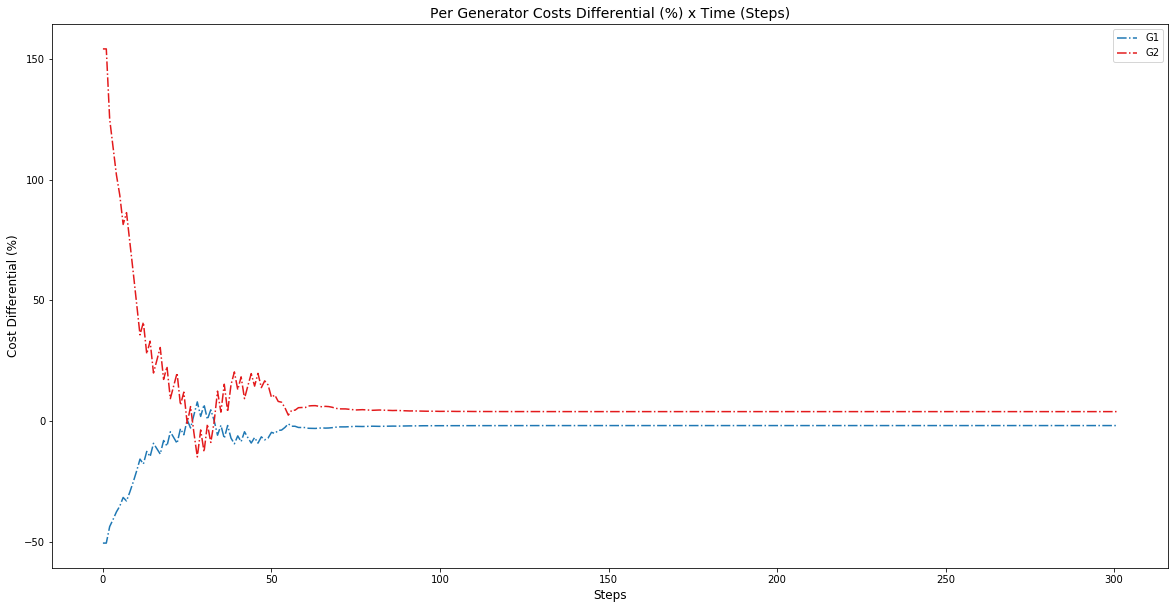

In [12]:
plotAll(electricalSystem.systemHistory)

In [13]:
# # Show the last episode ran during training
# from learning.learning_state import LearningState
# plotAll(LearningState().episode.electricalSystem.systemHistory)

In [14]:
for rewList in LearningState().model.allRewards:
    steps = range(len(rewList))
    plt.scatter(steps, rewList)
    
cummRew = LearningState().model.cummRewardList
steps = range(len(cummRew))
plt.scatter(steps, cummRew)
# len(LearningState().model.cummRewardList)

NameError: name 'LearningState' is not defined

In [ ]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [ ]:
allRewards = LearningState().model.allRewards


for r in allRewards[0::100]:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()

In [ ]:
rewardFn(0.1, 0.2, 0.3, 0.4)